## Transfer learning test - scoping out SEDE data

### Step 0: importation of stuff

In [1]:
library(tidyverse)
library(data.table)
library(distr)

── Attaching packages ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.4     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   2.0.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


Loading required package: startupmsg

Utilities for Start-Up Messages (version 0.9.6)

For more information see ?"startupmsg", NEWS("startupmsg")


Loading required package: sfsm

### Step 1: Exploring the data

In [2]:
raw_df = read_csv("data/sede_50000_3_30.csv")

Rows: 50000 Columns: 8

── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): Tags
dbl  (6): Id, PostId, Score, UserId, ViewCount, AnswerCount
dttm (1): CreationDate


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



In [3]:
raw_df = mutate(raw_df, Score = as.integer(Score), ViewCount = as.integer(ViewCount), AnswerCount = as.integer(AnswerCount))

In [4]:
head(raw_df)

Id,PostId,Score,CreationDate,UserId,Tags,ViewCount,AnswerCount
<dbl>,<dbl>,<int>,<dttm>,<dbl>,<chr>,<int>,<int>
120453196,68152730,163,2021-06-27 15:53:10,1169091,<python><python-3.x><list><indexing><swap>,20680,8
124341718,70340719,97,2021-12-13 20:49:56,2410359,<c++><arrays><initialization><undefined-behavior><zero-initialization>,5668,5
120453231,68152730,88,2021-06-27 15:55:31,1169091,<python><python-3.x><list><indexing><swap>,20680,8
124341696,70340719,82,2021-12-13 20:48:37,10686048,<c++><arrays><initialization><undefined-behavior><zero-initialization>,5668,5
125582897,71039947,78,2022-02-08 20:11:24,1196549,<c++><optimization><benchmarking><branch-prediction>,9565,9
121180438,1642028,74,2021-07-29 00:16:35,204555,<c><operators><code-formatting><standards-compliance>,906056,29


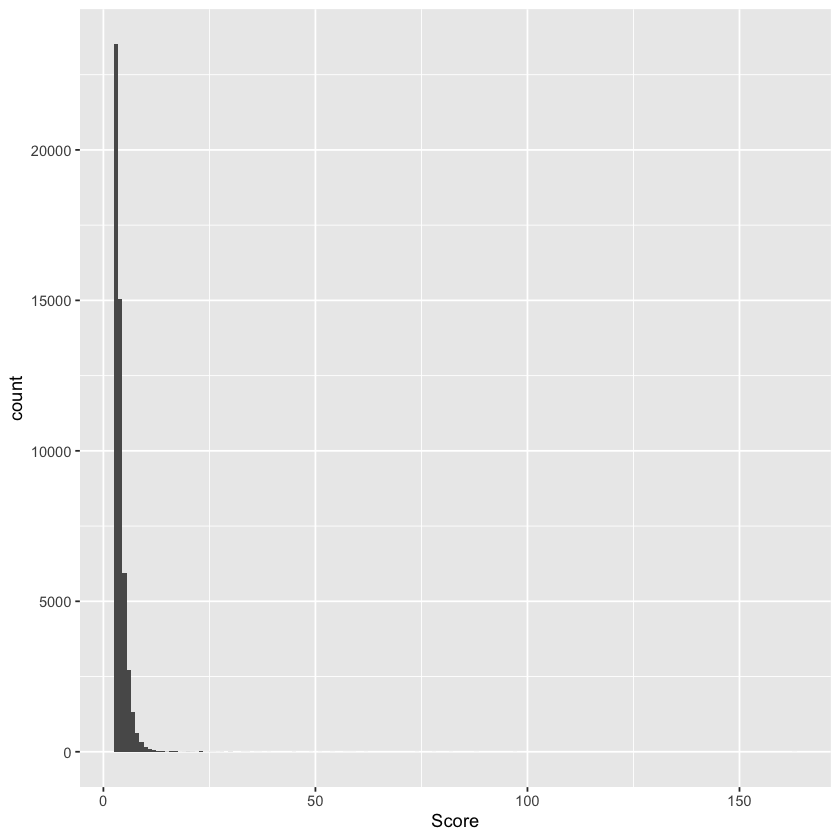

In [5]:
ggplot(raw_df, aes(x=Score)) + geom_histogram(binwidth=1)

UserId,n
<dbl>,<int>
1491895,737
440558,505
2029983,505
4117728,291
3003365,280
3689450,246


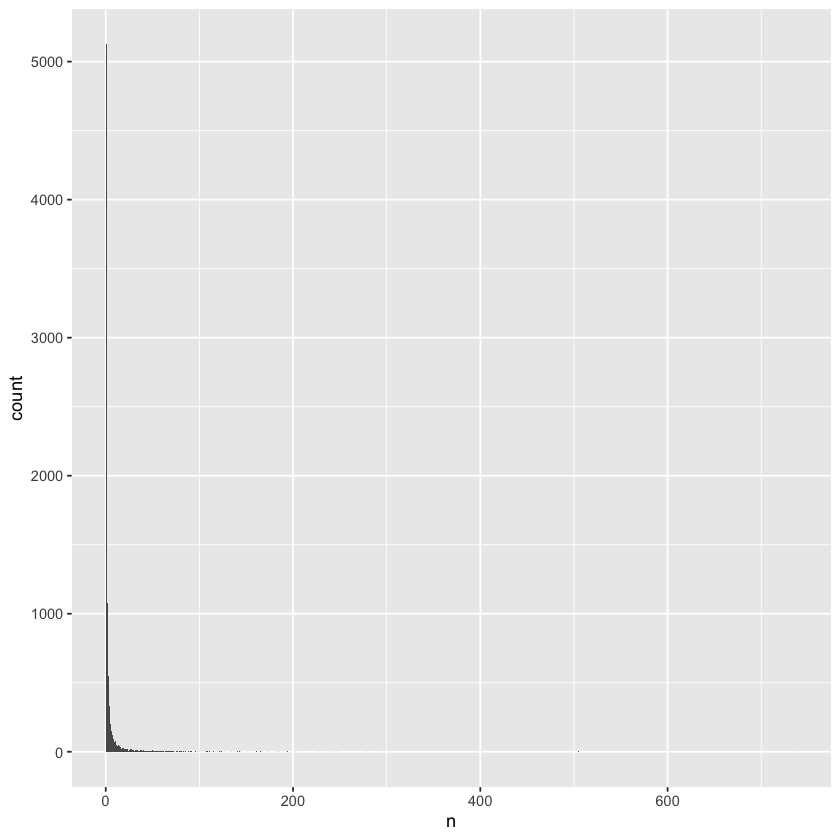

In [6]:
count_df = raw_df %>% count(UserId) %>% arrange(desc(n))

head(count_df)
ggplot(count_df, aes(x=n)) + geom_histogram(binwidth=1)

In [7]:
nrow(filter(count_df, n >= 30))

[1] 353

In [8]:
# is there a more time-efficient way to generate all tags?

tags = c()
for (i in c(1:nrow(raw_df))) {
    s = raw_df$Tags[i]
    s = as.list(strsplit(s, split="><")[[1]]) # why do I need to do this stupid syntax for full conversion
    s[1] = substring(s[1], 2)
    s[length(s)] = substring(s[length(s)],1,nchar(s[length(s)])-1)
    tags = union(tags, s)
#     print(s[1])
}
tags <- unlist(tags)

In [9]:
tags_df = data.frame(matrix(ncol=2,nrow=0))
for (i in c(1:length(tags))) {
    occurrences = nrow(filter(raw_df, grepl(paste("<",tags[i],">",sep=""), raw_df$Tags, fixed=TRUE)))
    tags_df= rbind(tags_df, c(tags[i], occurrences))
}
colnames(tags_df) <- c('tag', 'occurrences')

In [10]:
tags_df$occurrences <- as.numeric(tags_df$occurrences)

In [11]:
head(arrange(tags_df, desc(occurrences)), 10)

,tag,occurrences
,<chr>,<dbl>
1,python,8171
2,c++,7832
3,javascript,5182
4,c,4686
5,java,3875
6,c#,3644
7,sql,2373
8,arrays,1958
9,sql-server,1865


## Step 2: Filter out the data into in-sample and out-of-sample, using select tags

In [12]:
python_df = filter(raw_df, grepl("<python>", raw_df$Tags, fixed=TRUE))
cplusplus_df = filter(raw_df, grepl("<c++>", raw_df$Tags, fixed=TRUE))
javascript_df = filter(raw_df, grepl("<javascript>", raw_df$Tags, fixed=TRUE))
c_df = filter(raw_df, grepl("<c>", raw_df$Tags, fixed=TRUE))
java_df = filter(raw_df, grepl("<java>", raw_df$Tags, fixed=TRUE))

In [13]:
python_counts = python_df %>% select(c(UserId, Score)) %>% count(UserId) %>% filter(n>20)
cplusplus_counts = cplusplus_df %>% select(c(UserId, Score)) %>% count(UserId) %>% filter(n>20)
javascript_counts = javascript_df %>% select(c(UserId, Score)) %>% count(UserId) %>% filter(n>20)
c_counts = c_df %>% select(c(UserId, Score)) %>% count(UserId) %>% filter(n>20)
java_counts = java_df %>% select(c(UserId, Score)) %>% count(UserId) %>% filter(n>20)

In [14]:
python_df = merge(python_counts, python_df, by="UserId")
cplusplus_df = merge(cplusplus_counts, cplusplus_df, by="UserId")
javascript_df = merge(javascript_counts, javascript_df, by="UserId")
c_df = merge(c_counts, c_df, by="UserId")
java_df = merge(java_counts, java_df, by="UserId")

In [15]:
set.seed(1729)

in_sample_python = sample(unique(python_df$UserId), size = 0.8*length(unique(python_df$UserId)))
python_df.in = filter(python_df, UserId %in% in_sample_python)
python_df.out = filter(python_df, !UserId %in% in_sample_python)

in_sample_cplusplus = sample(unique(cplusplus_df$UserId), size = 0.8*length(unique(cplusplus_df$UserId)))
cplusplus_df.in = filter(cplusplus_df, UserId %in% in_sample_cplusplus)
cplusplus_df.out = filter(cplusplus_df, !UserId %in% in_sample_cplusplus)

in_sample_javascript = sample(unique(javascript_df$UserId), size = 0.8*length(unique(javascript_df$UserId)))
javascript_df.in = filter(javascript_df, UserId %in% in_sample_javascript)
javascript_df.out = filter(javascript_df, !UserId %in% in_sample_javascript)

in_sample_c = sample(unique(c_df$UserId), size = 0.8*length(unique(c_df$UserId)))
c_df.in = filter(c_df, UserId %in% in_sample_c)
c_df.out = filter(c_df, !UserId %in% in_sample_c)

in_sample_java = sample(unique(java_df$UserId), size = 0.8*length(unique(java_df$UserId)))
java_df.in = filter(java_df, UserId %in% in_sample_java)
java_df.out = filter(java_df, !UserId %in% in_sample_java)

## Step 3: Train the EB Model

We'll be using a Poisson DGP with a Gamma prior, assuming all comments had the same window to accumulate points.

In [16]:
in_sample_data <- list(python_in = python_df.in,
                       cplusplus_in = cplusplus_df.in,
                       javascript_in = javascript_df.in,
                       c_in = c_df.in,
                       java_in = java_df.in)

in_sample_names = c("python_in", "cplusplus_in", "javascript_in", "c_in", "java_in")

In [18]:
priors_df <- data.frame(matrix(ncol=3,nrow=0))

for (i in c(1:5)) {
    prior_df <- in_sample_data[[in_sample_names[i]]]
    prior_df <- group_by(prior_df, UserId) %>% summarize(avgScore = mean(Score))
    name <- in_sample_names[i]
    
    # alpha calculation derived from wikipedia - look more into theory here
    s <- log(mean(prior_df$avgScore)) - mean(log(prior_df$avgScore))
    alpha_est <- (3 - s + sqrt((s-3)^2 + 24 * s))/(12*s)
    
    # newton-raphson update
    for (i in c(1:20)) {
        alpha_est <- alpha_est - (log(alpha_est) - digamma(alpha_est) - s)/(1/alpha_est - trigamma(alpha_est))
    }
    
    beta_est <- 1/(mean(prior_df$avgScore)/alpha_est)
    
    priors_df <- rbind(priors_df, c(name, alpha_est, beta_est))
    
}
colnames(priors_df) <- c('name', 'alpha', 'beta')
priors_df$alpha <- as.numeric(priors_df$alpha)
priors_df$beta <- as.numeric(priors_df$beta)

In [29]:
priors_df

name,alpha,beta
<chr>,<dbl>,<dbl>
python_in,122.9263,30.51586
cplusplus_in,104.5532,23.70599
javascript_in,295.2146,76.56995
c_in,192.3016,45.10828
java_in,194.2652,48.29434


## Step 4: Test performance on test set

In [20]:
out_sample_data <- list(python_out = python_df.out,
                       cplusplus_out = cplusplus_df.out,
                       javascript_out = javascript_df.out,
                       c_out = c_df.out,
                       java_out = java_df.out)

out_sample_names = c("python_out", "cplusplus_out", "javascript_out", "c_out", "java_out")

In [21]:
out_sample_subset <- list(python_out = python_df.out,
                       cplusplus_out = cplusplus_df.out,
                       javascript_out = javascript_df.out,
                       c_out = c_df.out,
                       java_out = java_df.out)
out_sample_train <- list(python_out = 0, cplusplus_out = 0, javascript_out = 0, c_out = 0, java_out = 0)
out_sample_test <- list(python_out = 0, cplusplus_out = 0, javascript_out = 0, c_out = 0, java_out = 0)

In [22]:
for (i in c(1:5)) {
    temp <- filter(out_sample_subset[[i]], n >= 20) %>%
      group_by(UserId) %>% 
      arrange(CreationDate, .by_group = TRUE) %>%
      slice_head(n=20)
    out_sample_subset[[i]] = temp
    out_sample_train[[i]] = group_by(temp, UserId) %>% 
      arrange(CreationDate, .by_group = TRUE) %>%
      slice_head(n=10)
    out_sample_test[[i]] = group_by(temp, UserId) %>% 
      arrange(CreationDate, .by_group = TRUE) %>%
      slice_tail(n=10)

}

In [23]:
results_df <- data.frame(matrix(ncol=5,nrow=0))

for (i in c(1:5)) {
    out_sample <- out_sample_train[[out_sample_names[i]]]
    avg_df <- out_sample_subset[[out_sample_names[i]]] %>% group_by(UserId) %>% summarize(avgScore = mean(Score))
    out_sample <- merge(out_sample, avg_df, by="UserId")
    alpha <- drop(priors_df[i,]$alpha)
    beta <- drop(priors_df[i,]$beta)
    
    for (id in unique(out_sample$UserId)) {
        user_out_sample <- filter(out_sample, UserId==id)
        avg_score <- drop(user_out_sample$avgScore[1])
        user_alpha <- alpha + sum(user_out_sample$Score)
        user_beta <- beta + nrow(user_out_sample)
        theta_b <- (user_alpha - 1)/user_beta # MAP estimate
        theta_f <- mean(user_out_sample$Score) # MLE estimate in frequentist setting
        to_add <- c(out_sample_names[i], id, avg_score, theta_b, 'eb')
        results_df <- rbind(results_df, to_add)
        to_add <- c(out_sample_names[i], id, avg_score, theta_f, 'freq')
        results_df <- rbind(results_df, to_add)
    }
}

colnames(results_df) <- c('dataset', 'user', 'avg', 'estimated', 'method')

results_df$avg = as.numeric(results_df$avg)
results_df$estimated = as.numeric(results_df$estimated)

In [24]:
quantiles_df <- group_by(results_df, dataset) %>%
                summarize(quant25 = quantile(avg, probs = 0.25), 
                          quant50 = quantile(avg, probs = 0.5),
                          quant75 = quantile(avg, probs = 0.75))

In [25]:
results_df$quart = 0
for (i in c(1:nrow(results_df))) {
    ds = drop(results_df[i,]$dataset)
    quant25 = drop(filter(quantiles_df, dataset==ds)$quant25)
    quant50 = drop(filter(quantiles_df, dataset==ds)$quant50)
    quant75 = drop(filter(quantiles_df, dataset==ds)$quant75)
    user_avg <- drop(results_df[i,]$avg)
    if (user_avg < quant25) {
        results_df[i,]$quart = 1
    } else if (between(user_avg, quant25, quant50)) {
        results_df[i,]$quart = 2
    } else if (between(user_avg, quant50, quant75)) {
        results_df[i,]$quart = 3
    } else {
        results_df[i,]$quart = 4
    }
}

In [26]:
results_df$sq_error = (results_df$avg - results_df$estimated)^2

In [27]:
graphed_df = group_by(results_df, dataset, method, quart) %>% summarize(avg = mean(avg), mse = mean(sq_error))

`summarise()` has grouped output by 'dataset', 'method'. You can override using the `.groups` argument.



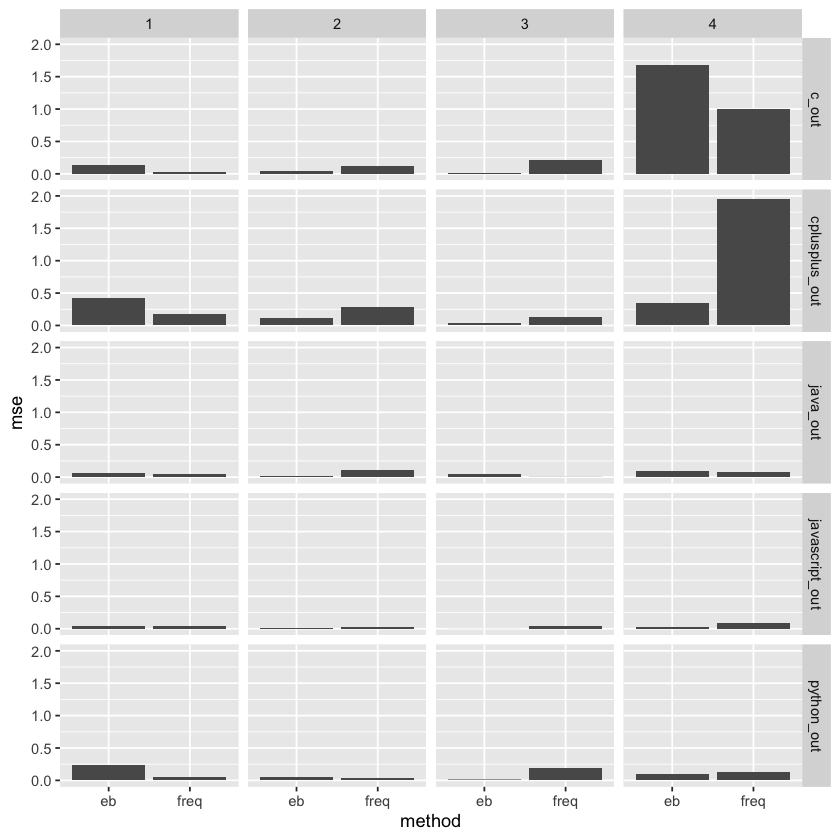

In [30]:
ggplot(graphed_df) + 
    geom_bar(aes(x=method,y=mse), stat='identity') +
    facet_grid(rows = vars(dataset), cols=vars(quart)) +
    scale_y_continuous(name="mse", limits=c(0, 2))

In [144]:
ggplot(results_df) + 
    geom_bar(aes(x=quart,y=sq_error), stat='identity') +
    facet_grid(rows = vars(num_train), cols=vars(method)) +
    scale_y_continuous(name="mean distance", limits=c(0, 1))

dataset,quant25,quant50,quant75
<chr>,<dbl>,<dbl>,<dbl>
c_out,3.8,4.15,4.3


In [142]:
table(cut(results_df$avg, b = 4))


(3.25,3.91] (3.91,4.58] (4.58,5.24]  (5.24,5.9] 
         62          44           6           6 